### Import

In [24]:
import torch
import torch.nn as nn
import math

### Input Embedding

Embeddings are just vector representation of words. So, Input Embedding just means<br>
the vector representation of inputs. i.e mapping between words and vectors.<br><br>

According to paper *Attention is all you need*, the embedding dimension is `512`.<br>
Meaning that each word is represented using a vector of dimension `(1, 512)`.<br>
Let's go:

First of all, we need two things :<br>


1.   `d_model` : Dimension of the model (Embedding Dimension), which is basically 512 in our case.
2.   `vocab_size` : Size of our dictionary.

Now, torch already provides us with a class for generating word embeddings. i.e `nn.Embedding`.



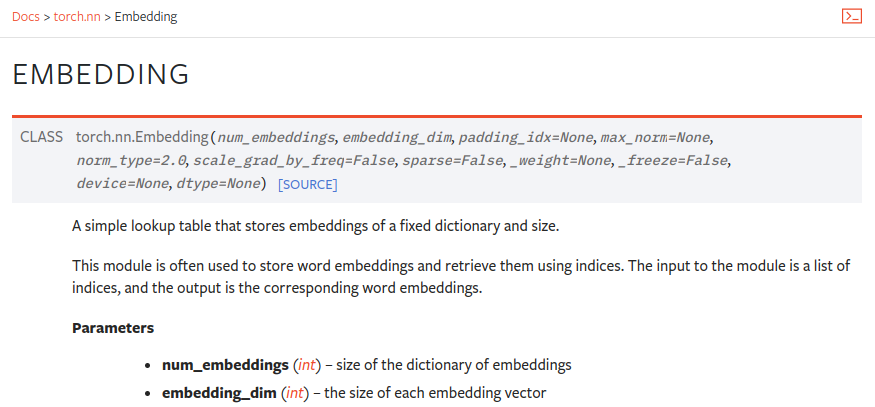

Also, in the paper, we can see that embeddings are multiplied by the square root of `d_model`.<br>
<br>
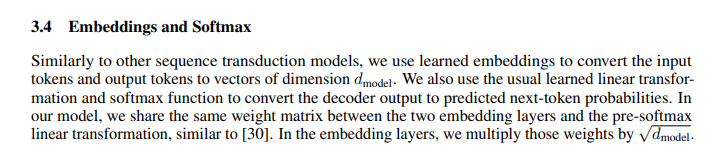

In [25]:
class InputEmbeddings(nn.Module):

    def __init__(self, d_model:int, vocab_size:int):
        super().__init__()
        self.d_model = d_model
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, d_model)

    def forward(self, x):
        return self.embedding(x) * math.sqrt(self.d_model)

The layer to generate input embedding is ready. Let's move on to *Positional Encoding*.

### Positional Encoding

Since we’re dealing with natural language, the positions and order of the words are extremely important as sentences<br>
follow grammatical rules and different order of the same words can give different meanings. In transformer models,<br>
each word in a sentence flows through the encoder/decoder stack simultaneously and the model itself doesn’t have<br>any sense of position/order for each word. Therefore, there’s a need to incorporate the order of the words into the model.

For this purpose, we use positional encodings.<br><br>

For Positional Encodings, we need following :


1.   `d_model` : Dimension of the model (Embedding Dimension), which is basically 512 in our case.
2.   `seq_len` : Sequence length of input, as we need to create a vector for input of each position.
3.   `dropout` : It's just hyperparameter to prevent overfitting.

For `dropout` also, we have got built in class in torch.<br><br>
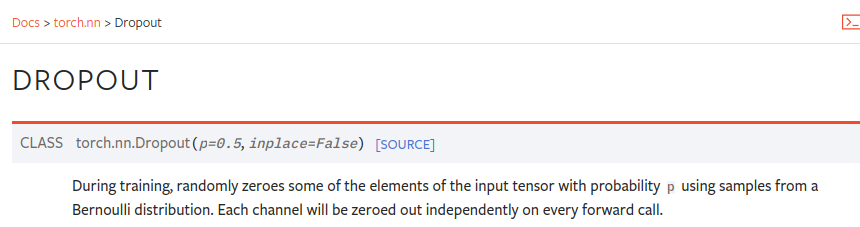

We also need to build a matrix of `seq_len x d_model` because we need vectors of size `d_model` for our input of `seq_len` input length.

Then, we build our positional encodings using the specified equations in the paper.<br><br>
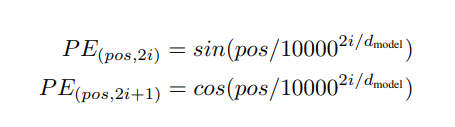

In [26]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model:int, seq_len:int, dropout:float) -> None:
        super().__init__()
        self.d_model = d_model
        self.seq_len = seq_len
        self.dropout = nn.Dropout(dropout)

        # Matrix of shape (seq_len, d_model)
        pe = torch.zeros(seq_len, d_model)  # pe is basically short for positional encodings.

        # Create vector of shape (seq_len, 1) (We did this in order to apply equation on each of the input.)
        position = torch.arange(0, seq_len, dtype = torch.float).unsqueeze(1)

        # Denominator
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0)/d_model))

        # Apply sine to even positions
        pe[:, 0::2] = torch.sin(position * div_term)

        # Apply cosine to odd positions
        pe[:, 1::2] = torch.cos(position * div_term)

        # We will not just have a single sequence but instead, we'll have batch dimension. So, let's incorporate the batch dimension.
        pe = pe.unsqueeze(0) # -> (1, seq_len, d_model)

        # Save positional encodings in register buffer because we are not going to learn these values and they'll be same for each sequence.
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + (self.pe[:, :x.shape(1), :]).requires_grad_(requires_grad = False) # We donot need to learn positional embeddings. So, we donot need to compute gradient.
        return self.dropout(x)

### Layer Normalization

*Layer normalization* is quiet different from *batch normalization*.<br><br>
The key difference is that, in *batch normalization*, for each neuron, we consider multiple batches and calculate the respective mean and standard deviation. So, the *batch normalization* approach have some problems such as : hard to use with sequence data, have high computational complexity and if batch size is very small, it's not of much use.<br>
<br>
Whereas in *Layer Normalization*, mean and standard deviation is calculated across each layer. Even if we have multiple batches, we normalilze based on a single layer data of single batch only. And this approach is also applicable while inference.

The parameters we need for layer normalization are:<br>
1.   Epsilon, i.e.`eps` which is usually very small value. And it is necessary just to prevent division by zero.
2.   `alpha`, which is multiplicative parameter.
3.   `bias` which is additive paramerer.
<br><br>

Parameters `alpha` and `bias` are just for introducing fluctuations in data because having all the values between 0 & 1 might be too restrictive.

The difference between `keepdim=False` and `keepdim=True`. i.e. Usually the dimension along which mean is applied is cancelled but <br>`keepdim = True` keeps it.
<br><br>
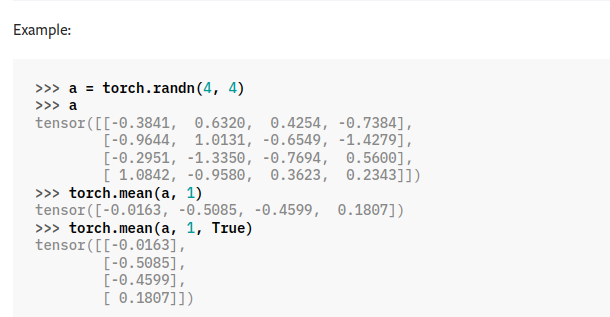

In [51]:
class LayerNormalization(nn.Module):

    def __init__(self, features:int, eps: float = 10**-6) ->None:
        super().__init__()
        self.eps = eps
        self.alpha = nn.Parameter(torch.ones(features)) # Multiplicative
        self.bias = nn.Parameter(torch.zeros(features)) # Additive

    def forward(self, x):
        mean = x.mean(dim = -1, keepdim = True)
        std = x.std(dim = -1, keepdim = True)

        return self.alpha * (x - mean)/(std + self.eps) + self.bias

### Feed Forward Layer

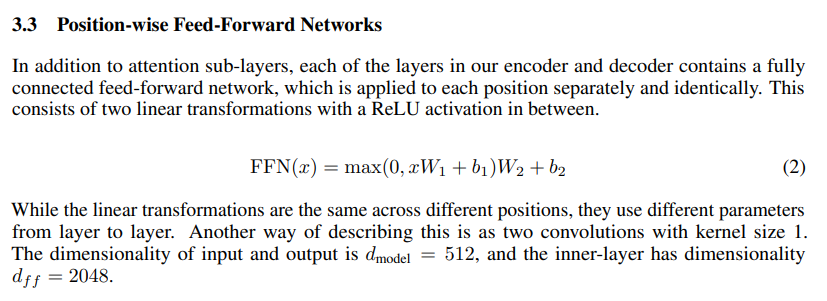

So, feed forward basically means that we compute values for first set of weights and biases, apply ReLU to it and then <br>
compute values for second set of weights and biases.<br><br>

Another important stuff to notice is that `d_model` is `512` (because it's input) whereas the inner-layer dimensionality `d_ff` is `2048`.<br>
The dimension for layers will look like this : `512 -> 2048 -> 512`.

In [28]:
class FeedForwardBlock(nn.Module):

    def __init__(self, d_model:int, d_ff:int, dropout:float) -> None:
        super().__init__()
        self.linear_1 = nn.Linear(d_model, d_ff) # -> For first set of w & b
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model) # -> For second set of w & b

    def forward(self, x):
        '''
        On applying the first linear layer, our input changes as below :
        (batch_size, seq_len, d_model) --> (batch_size, seq_len, d_ff),

        Again on applying the second linear layer, it changes as below:
        (batch_size, seq_len, d_ff) --> (batch_size, seq_len, d_model)
        '''
        return self.linear_2(self.dropout(torch.relu(self.linear_1(x))))

### Multi Head Attention

Now, for Multi headed attention: <br><br>
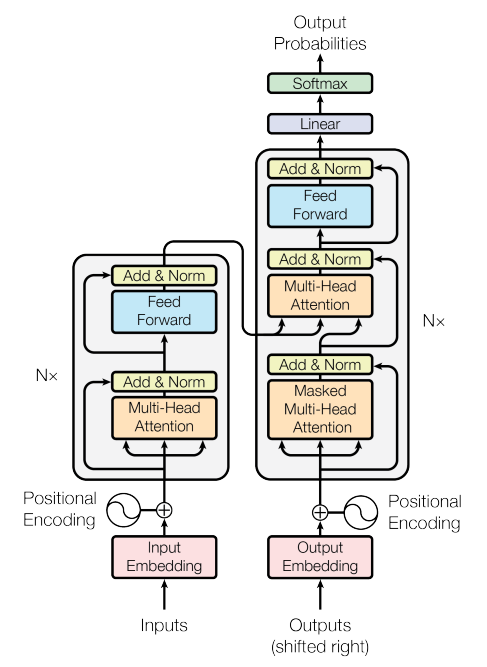

We can see that after adding input embeddings with positional encodings, we send the input to Multi-Head Attention (MHA) block.<br>
But, we also see that one input gets in MHA block as 3 inputs. Let's learn about that.<br><br>
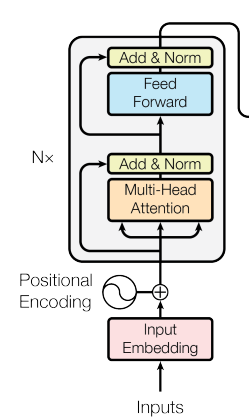

The three inputs are `key`, `query` and `value` matrices.<br>
The purpose of `key` and `query` matrix is to apply linear transformation for efficient representation while `value`<br>is used to incorporate the context.
<br>
<br>
For that, we first initialize `key`, `query` and `value` matrices randomly.<br><br>
The shape of each of the `key`, `query` and `value` matrix is actually `(d_model, d_model)` i.e. `(512, 512)` in our case.
<br>
The shape of input after converting the word input to `embedding` and adding `positional encoding` information
<br>for a single input is : `(1, seq_len, d_model)`. So, for a input of batch size `batch_size`,<br>
the input shape is `(batch_size, seq_len, d_model)`. <br>
Since, `d_model` = `512`, the input shape is `(batch_size, seq_len, 512)`.

Now, we multiply input with each of `key`, `query` and `value` matrix.<br>
Since, all of them are of dimension `(512, 512)`, the `key`, `query` and `value` matrix<br>
have now have the dimension, `(batch_size, seq_len, d_model)` i.e.`(batch_size, seq_len, 512)`.<br><br>

For multi-head attention, we need to divide input into multiple heads denoted by `h`. <br>
`h` should be a number that should perfectly divide `d_model`, `8` in our case.<br><br>
So, we reshape our `key`, `query` and `value` matrix from `(batch_size, seq_len, d_model)`,<br>to `(batch_size, seq_len, h, d_k)`.<br>
Here, `d_k` is the dimension of `key` in each head, and it is same for query and value. i.e `64`. <br> So, in our case the input dimension is now : <br>
`(batch_size, seq_len, 8, 64)` for all `key`, `query` and `value`.<br>
Now, we again reshape our `key`, `query` and `value` matrix, to the shape<br>
`(batch_size, 8, seq_len, 64)`.

Now, we calculate attention using those `key`, `query` and `value`.<br>
We have implemented the attention calculation process in `@staticmethod attention` below:<br>
First, we do matrix multiplication on `query` and `transpose of key`.<br>
The dimension of `query` is `(batch_size, 8, seq_len, 64)`, and that of transposed<br>`key` is `(batch_size, 8, 64, seq_len)`.

The matrix multiplication gives the output of shape `(batch_size, 8, seq_len, seq_len)`.<br>This means, we actually applied transformation for each word against each word in the sequence.<br>

And we divide the output by the square root of `d_k` in order to normalize things as they can get<br>
extremly large or small during matrix multiplication. And the resulting shape is again :<br>`(batch_size, 8, seq_len, seq_len)`.<br><br>

Now, we do softmax, dropout and stuffs like that and then do it's matrix multiplication with `value`.<br><br>

Since, our current output have dimension : `(batch_size, 8, seq_len, seq_len)` <br>
and `value` matrix have dimension : `(batch_size, 8, seq_len, 64)`, <br>the matrix multiplication will result in output of dimension : `(batch_size, 8, seq_len, 64)`.


After the attention operation, we change the shape of output back to <br>
`(batch_size, seq_len, d_model)` i.e.`(batch_size, seq_len, 512)` which is basically concating<br> the heads to get whole output.<br> Then we again pass the output through linear layer.<br><br>
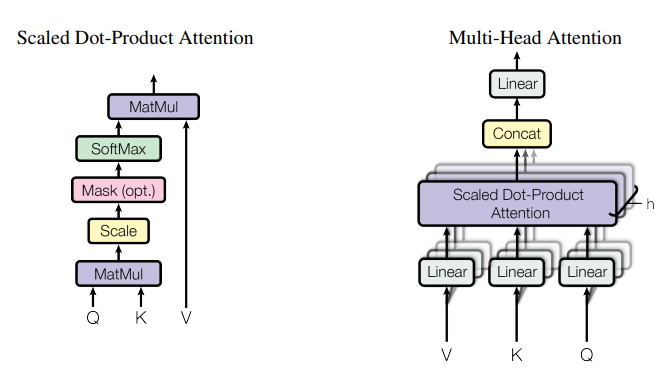

In [29]:
class MultiHeadAttentionBlock(nn.Module):

    def __init__(self, d_model:int, h: int, dropout:float) -> None:
        super().__init__()
        self.d_model = d_model
        self.h = h
        assert d_model % h == 0, "d_model is not divisible by h"
        self.d_k = d_model // h

        # Initialize K, Q, V matrices
        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)

        self.w_o = nn.Linear(d_model, d_model)
        self.drouput = nn.Dropout(dropout)


    @staticmethod
    def attention(query, key, value, mask, dropout:nn.Dropout):
        d_k = query.shape[-1]

        # (batch_size, h, seq_len, d_k) -->q.k(T)--> (batch_size, h, seq_len, seq_len)
        attention_scores = (query @ key.transpose(-2, -1)) / math.sqrt(d_k)

        if mask is not None:
            attention_scores.masked_fill_(mask == 0, -1e9)

        attention_scores = attention_scores.softmax(dim = -1)

        if dropout is not None:
            attention_scores = dropout(attention_scores)

        # (batch_size, h, seq_len, seq_len) -->(attention_scores @ value)--> (batch_size, h, seq_len, d_k)
        return (attention_scores @ value), attention_scores



    def forward(self, q, k, v, mask):
        query = self.w_q(q) # (batch_size, seq_len, d_model) --> (batch_size, seq_len, d_model)
        key = self.w_k(k) # (batch_size, seq_len, d_model) --> (batch_size, seq_len, d_model)
        value = self.w_v(v) # (batch_size, seq_len, d_model) --> (batch_size, seq_len, d_model)

        # Divide the Q, K, V into multiple heads.
        # (batch_size, seq_len, d_model) --->view()---> (batch_size, seq_len, h, d_k) -->transpose()--> (batch_size, h, seq_len, d_k)
        query = query.view(query.shape[0], query.shape[1], self.h, self.d_k).transpose(1, 2)
        key = key.view(key.shape[0], key.shape[1], self.h, self.d_k).transpose(1, 2)
        value = value.view(value.shape[0], value.shape[1], self.h, self.d_k).transpose(1, 2)

        x, self.attention_scores = MultiHeadAttentionBlock.attention(query, key, value, mask, self.dropout)

        # (batch_size, h, seq_len, d_k) -->transpose()--> (batch_size, seq_len, h, d_k)
        # (batch_size, seq_len, h, d_k) -->view()--> (batch_size, seq_len, d_model)
        # Note : d_model = h * d_k
        x = x.transpose(1, 2).contiguous().view(x.shape[0], -1, self.h * self.d_k)
        # We keep -1 in the middle to kind of let .view() get the remaining dim automatically.

        # (batch, seq_len, d_model) -->Linear--> (batch, seq_len, d_model)
        return self.w_o(x)

### Residual Connection

It's just a skip connection.<br>
`x` is the current output.<br>
`sublayer` is the output from where we're having residual connection.

In [41]:
class ResidualConnection(nn.Module):

    def __init__(self, features:int, dropout:float) -> None:
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.norm = LayerNormalization(features)


    def forward(self, x, sublayer):
        return x + self.dropout(sublayer(self.norm(x)))

### Encoder

We do have encoder that consists of Multi-Head Attention block, Add and Norm block & Feed Forward block<br>and we do have `Nx` number of such blocks, which is `6` in our case. And the way operation happens is that the <br> output of first encoder is sent as input to second encoder, second to third, and all the way to last one.<br> The output of final one is then sent to the `Decoder` block.

In [44]:
class EncoderBlock(nn.Module):

    def __init__(self, features:int, self_attention_block:MultiHeadAttentionBlock, feed_forward_block:FeedForwardBlock, dropout:float) -> None:
        super().__init__()
        self.self_attention_block = self_attention_block
        self.feed_forward_block = feed_forward_block
        self.residual_connections = nn.ModuleList([ResidualConnection(features, dropout) for _ in range(2)])


    def forward(self, x, src_mask):
        x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, src_mask))
        x = self.residual_connections[1](x, self.feed_forward_block)
        return x

We've created a single encoder block. Now let's do it for `Nx` of them.

In [55]:
class Encoder(nn.Module):

    def __init__(self, features:int, layers:nn.ModuleList) -> None:
        super().__init__()
        self.layers = layers
        self.norm = LayerNormalization(features)

    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

### Decoder

The decoder is also composed of a stack of N = 6 identical layers. In addition to the two<br>
sub-layers in each encoder layer, the decoder inserts a third sub-layer, which performs multi-head<br>
attention over the output of the encoder stack. It's basically same as encoder with one extra attention block<br>which is not self-attention but actually cross-attention.

In [53]:
class DecoderBlock(nn.Module):

    def __init__(self, features:int, self_attention_block:MultiHeadAttentionBlock, cross_attention_block:MultiHeadAttentionBlock, feed_forward_block:FeedForwardBlock, dropout:float) -> None:
        super().__init__()
        self.self_attention_block = self_attention_block
        self.cross_attention_block = cross_attention_block
        self.feed_forward_block = feed_forward_block
        self.residual_connections = nn.ModuleList([ResidualConnection(features, dropout) for _ in range(3)])


    def forward(self, x, encoder_output, src_mask, tgt_mask):
        x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, tgt_mask))
        x = self.residual_connections[1](x, lambda x: self.self_attention_block(x, encoder_output, encoder_output, src_mask))
        x = self.residual_connections[2](x, self.feed_forward_block)
        return x

We've created a single decoder block. Now let's do it for Nx of them.

In [56]:
class Decoder(nn.Module):

    def __init__(self, features:int, layers:nn.ModuleList) -> None:
        super().__init__()
        self.layers = layers
        self.norm = LayerNormalization(features)

    def forward(self, x, encoder_output, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, encoder_output, src_mask, tgt_mask)
        return self.norm(x)

### Projection Layer

After the decoder layer, there is a `Linear` layer and a `Softmax` layer. Let's do it.<br>
We need the `Linear` layer because we need to map the output from the decoder, which is of dimension :<br>
`(batch_size, seq_len, d_model)` in the target language. So, the mapped output will be of dimension : `(batch_size, seq_len, vocab_size)`.

In [35]:
class ProjectionLayer(nn.Module):

    def __init__(self, d_model:int, vocab_size:int) -> None:
        super().__init__()
        self.proj = nn.Linear(d_model, vocab_size)

    def forward(self, x):
        return torch.log_softmax(self.proj(x), dim = -1)

Every component is complete. Let's build the entire transformer block.

### Transformer

In [36]:
class Transformer(nn.Module):

    def __init__(self, encoder:Encoder, decoder:Decoder, src_embed:InputEmbeddings, tgt_embed: InputEmbeddings, src_pos:PositionalEncoding, tgt_pos:PositionalEncoding, projection_layer:ProjectionLayer) -> None:
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.src_pos = src_pos
        self.tgt_pos = tgt_pos
        self.projection_layer = projection_layer


    def encode(self, src, src_mask):
        src = self.src_embed(src)
        src = self.src_pos(src)
        return self.encoder(src, src_mask)

    def decode(self, encoder_output, src_mask, tgt, tgt_mask):
        src = self.tgt_embed(src)
        src = self.tgt_pos(src)
        return self.decoder(tgt, encoder_output, src_mask, tgt_mask)

    def project(self, x):
        return self.projection_layer(x)

### Build Transformer

We have got every block ready. So, lets initialize the model with the hyperparameters specified in the paper and also do some initialization stuff on the actual neurons.

In [60]:
def build_transformer(features:int, src_vocab_size:int, tgt_vocab_size:int, src_seq_len:int, tgt_seq_len:int,
                      d_model:int = 512, N:int = 6, h:int = 8, dropout:float = 0.1, d_ff:int = 2048,) -> Transformer:

    # Create the embedding layers
    src_embed = InputEmbeddings(d_model, src_vocab_size)
    tgt_embed = InputEmbeddings(d_model, tgt_vocab_size)

    # Create positional encodings
    src_pos = PositionalEncoding(d_model, src_seq_len, dropout)
    tgt_pos = PositionalEncoding(d_model, tgt_seq_len, dropout)

    # Create encoder blocks
    encoder_blocks = []
    for _ in range(N):
        encoder_self_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
        feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout)
        encoder_block = EncoderBlock(features, encoder_self_attention_block, feed_forward_block, dropout)
        encoder_blocks.append(encoder_block)

    # Create decoder blocks
    decoder_blocks = []
    for _ in range(N):
        decoder_self_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
        decoder_cross_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
        feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout)
        decoder_block = DecoderBlock(features, decoder_self_attention_block, decoder_cross_attention_block, feed_forward_block, dropout)
        decoder_blocks.append(decoder_block)


    # Create Encoder-Decoder combined
    encoder = Encoder(d_model, nn.ModuleList(encoder_blocks))
    decoder = Decoder(d_model, nn.ModuleList(decoder_blocks))

    # Create a projection layer
    projection_layer = ProjectionLayer(d_model, tgt_vocab_size)

    # Create the transformer
    transformer = Transformer(encoder, decoder, src_embed, tgt_embed, src_pos, tgt_pos, projection_layer)

    # Initialize neurons
    for p in transformer.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)

    return transformer

In [61]:
my_tf = build_transformer(1, 20000, 20000, 500, 500)

In [63]:
my_tf

Transformer(
  (encoder): Encoder(
    (layers): ModuleList(
      (0-5): 6 x EncoderBlock(
        (self_attention_block): MultiHeadAttentionBlock(
          (w_q): Linear(in_features=512, out_features=512, bias=True)
          (w_k): Linear(in_features=512, out_features=512, bias=True)
          (w_v): Linear(in_features=512, out_features=512, bias=True)
          (w_o): Linear(in_features=512, out_features=512, bias=True)
          (drouput): Dropout(p=0.1, inplace=False)
        )
        (feed_forward_block): FeedForwardBlock(
          (linear_1): Linear(in_features=512, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear_2): Linear(in_features=2048, out_features=512, bias=True)
        )
        (residual_connections): ModuleList(
          (0-1): 2 x ResidualConnection(
            (dropout): Dropout(p=0.1, inplace=False)
            (norm): LayerNormalization()
          )
        )
      )
    )
    (norm): LayerNormalization()
 